In [32]:
from datetime import datetime, timedelta
from pathlib import Path
from typing import Union

import janitor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize": (10, 6)})

In [33]:
data_dir = Path("..", "data", "dataframes")
nws_df_path = data_dir / "national-weather-service.pkl"
cc_df_path = data_dir / "climacell.pkl"
owm_df_path = data_dir / "open-weather-map.pkl"

START_DATE = "2021-03-28 12:00:00"

In [34]:
def convert_f_to_c(f: np.ndarray) -> np.ndarray:
    return (f - 32.0) / 1.8

In [35]:
nws_df = pd.read_pickle(nws_df_path).clean_names()
nws_df["temperature"] = convert_f_to_c(nws_df["temperature"].values)
nws_df["temperatureunit"] = "C"
nws_df = nws_df[nws_df["starttime"] >= START_DATE]
nws_df = nws_df.reset_index(drop=True)
nws_df.head()

,detailedforecast,shortforecast,starttime,endtime,icon,isdaytime,name,number,temperature,temperatureunit,temperaturetrend,winddirection,windspeed,collection_timestamp,city,forecast_type
0,"Sunny, with a high near 52. West wind 18 to 23...",Sunny,2021-03-29 14:00:00-04:00,2021-03-29 18:00:00-04:00,https://api.weather.gov/icons/land/day/wind_sk...,True,This Afternoon,1,11.111111,C,None,W,18 to 23 mph,2021-03-29 18:23:29.503596,tuscon,daily
1,"Clear, with a low around 28. West wind 5 to 15...",Clear,2021-03-29 18:00:00-04:00,2021-03-30 06:00:00-04:00,https://api.weather.gov/icons/land/night/skc?s...,False,Tonight,2,-2.222222,C,None,W,5 to 15 mph,2021-03-29 18:23:29.503596,tuscon,daily
2,"Sunny, with a high near 54. Southwest wind 3 t...",Sunny,2021-03-30 06:00:00-04:00,2021-03-30 18:00:00-04:00,https://api.weather.gov/icons/land/day/skc?siz...,True,Tuesday,3,12.222222,C,None,SW,3 to 15 mph,2021-03-29 18:23:29.503596,tuscon,daily
3,"Partly cloudy, with a low around 44. South win...",Partly Cloudy,2021-03-30 18:00:00-04:00,2021-03-31 06:00:00-04:00,https://api.weather.gov/icons/land/night/sct?s...,False,Tuesday Night,4,6.666667,C,None,S,10 to 14 mph,2021-03-29 18:23:29.503596,tuscon,daily
4,"Partly sunny, with a high near 63. South wind ...",Partly Sunny,2021-03-31 06:00:00-04:00,2021-03-31 18:00:00-04:00,https://api.weather.gov/icons/land/day/bkn?siz...,True,Wednesday,5,17.222222,C,None,S,10 to 16 mph,2021-03-29 18:23:29.503596,tuscon,daily


In [36]:
def plot_forecast_against_actual(
    forecast_df: pd.DataFrame,
    current_df: pd.DataFrame,
    x: str,
    y: str,
    timestamp_col: str = "collection_timestamp",
) -> gg.ggplot:
    return (
        gg.ggplot(forecast_df, gg.aes(x=x, y=y))
        + gg.facet_wrap("~ city", ncol=2, scales="free_y")
        + gg.geom_line(gg.aes(group=f"factor({timestamp_col})"), alpha=0.2)
        + gg.geom_line(data=current_df, color="red")
        + gg.scale_x_datetime(date_labels="%m-%d")
        + gg.theme_minimal()
        + gg.theme(
            figure_size=(10, 15),
            axis_text_x=gg.element_text(angle=35, size=7),
            axis_text_y=gg.element_text(size=7),
            strip_background=gg.element_blank(),
            strip_text=gg.element_text(face="bold"),
            subplots_adjust=dict(wspace=0.1),
        )
        + gg.labs(x=None, y="temperature (C)")
    )

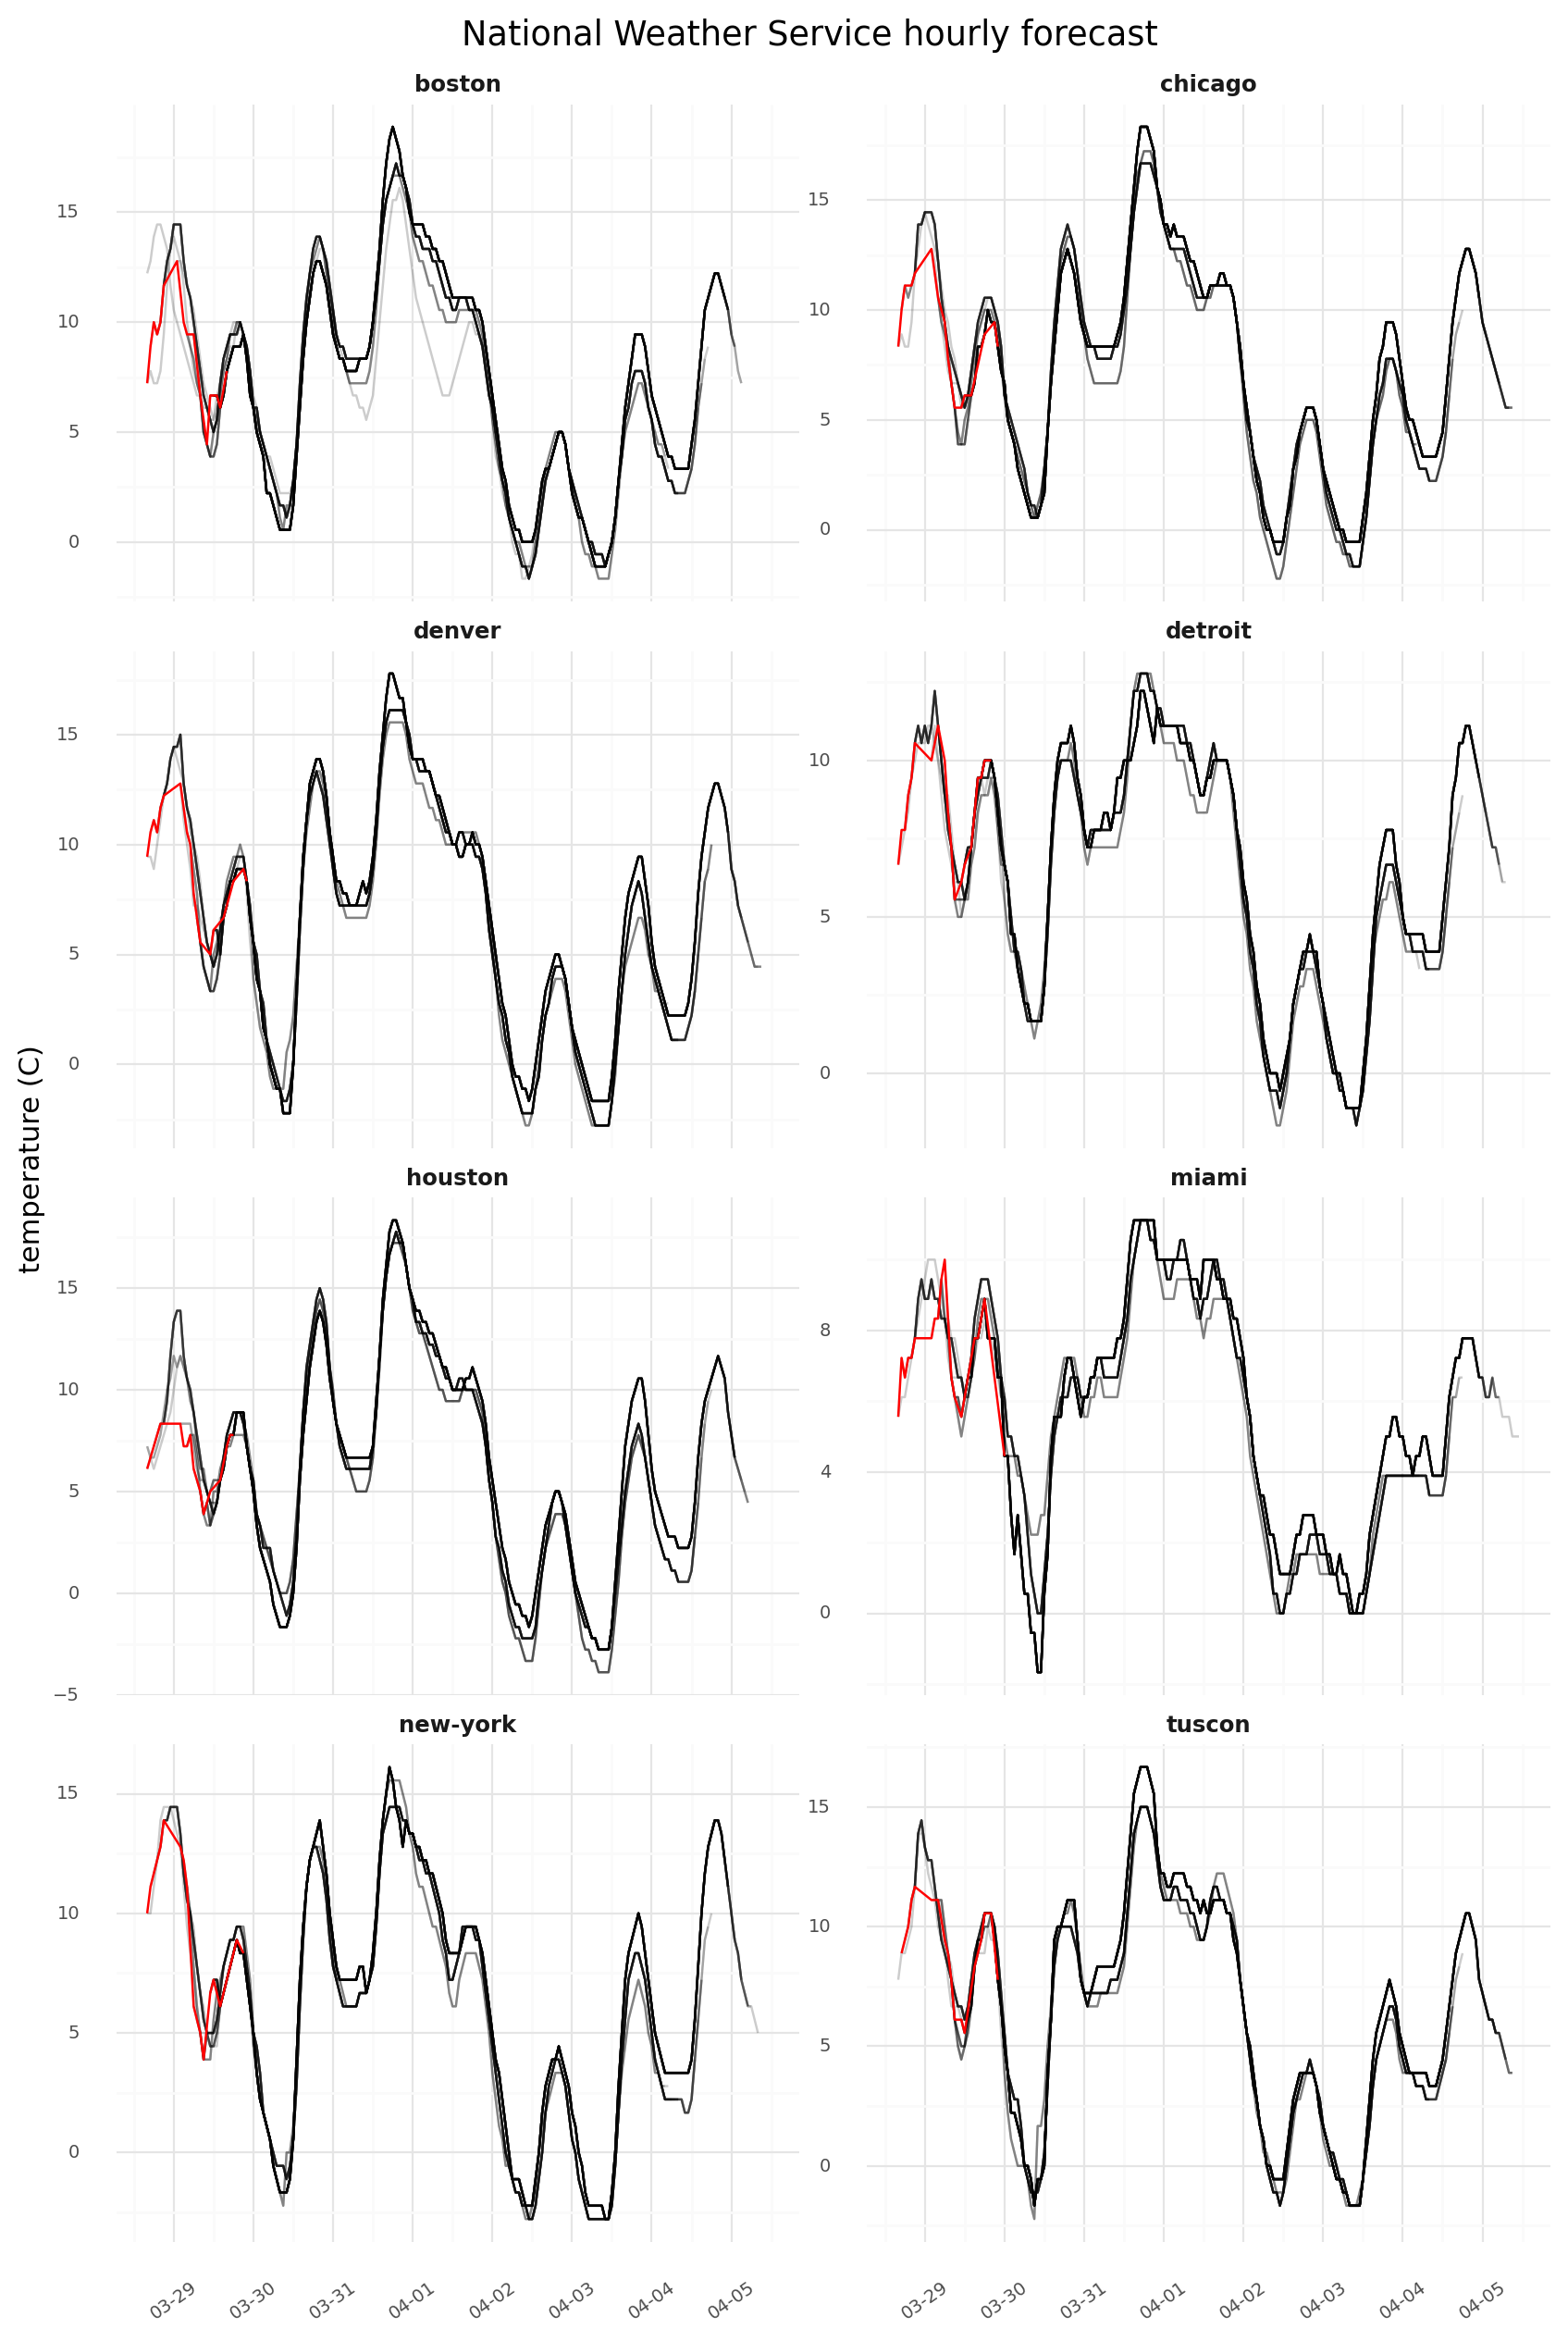

<ggplot: (319183448)>

In [37]:
nws_hourly = nws_df.copy()[nws_df["forecast_type"] == "hourly"]
nws_current = nws_hourly.copy()[nws_hourly["number"] == 1]

plot_forecast_against_actual(
    nws_hourly,
    nws_current,
    x="starttime",
    y="temperature",
) + gg.labs(title="National Weather Service hourly forecast")

## ClimaCell

In [38]:
cc_df = pd.read_pickle(cc_df_path).clean_names()
cc_df = cc_df[cc_df.collection_timestamp >= START_DATE]
cc_df.head()

,temperature,temperatureapparent,precipitationintensity,precipitationprobability,precipitationtype,visibility,cloudcover,weathercode,humidity,windspeed,starttime,forecast_type,collection_timestamp,city
0,1.33,-3.07,0.0,0.0,1.0,11.44,25.31,1100,62.56,4.81,2021-03-29 05:22:00+00:00,current,2021-03-29 05:22:08.575221,detroit
1,1.33,-3.07,0.0,0.0,1.0,11.44,25.31,1100,62.56,4.81,2021-03-29 05:22:00+00:00,hourly,2021-03-29 05:22:08.575221,detroit
2,-0.45,-4.55,0.0,0.0,1.0,16.00,0.00,1000,69.22,3.60,2021-03-29 06:22:00+00:00,hourly,2021-03-29 05:22:08.575221,detroit
3,-0.66,-4.58,0.0,0.0,1.0,16.00,0.00,1000,71.37,3.34,2021-03-29 07:22:00+00:00,hourly,2021-03-29 05:22:08.575221,detroit
4,-0.83,-4.25,0.0,0.0,1.0,16.00,0.00,1000,74.18,2.75,2021-03-29 08:22:00+00:00,hourly,2021-03-29 05:22:08.575221,detroit


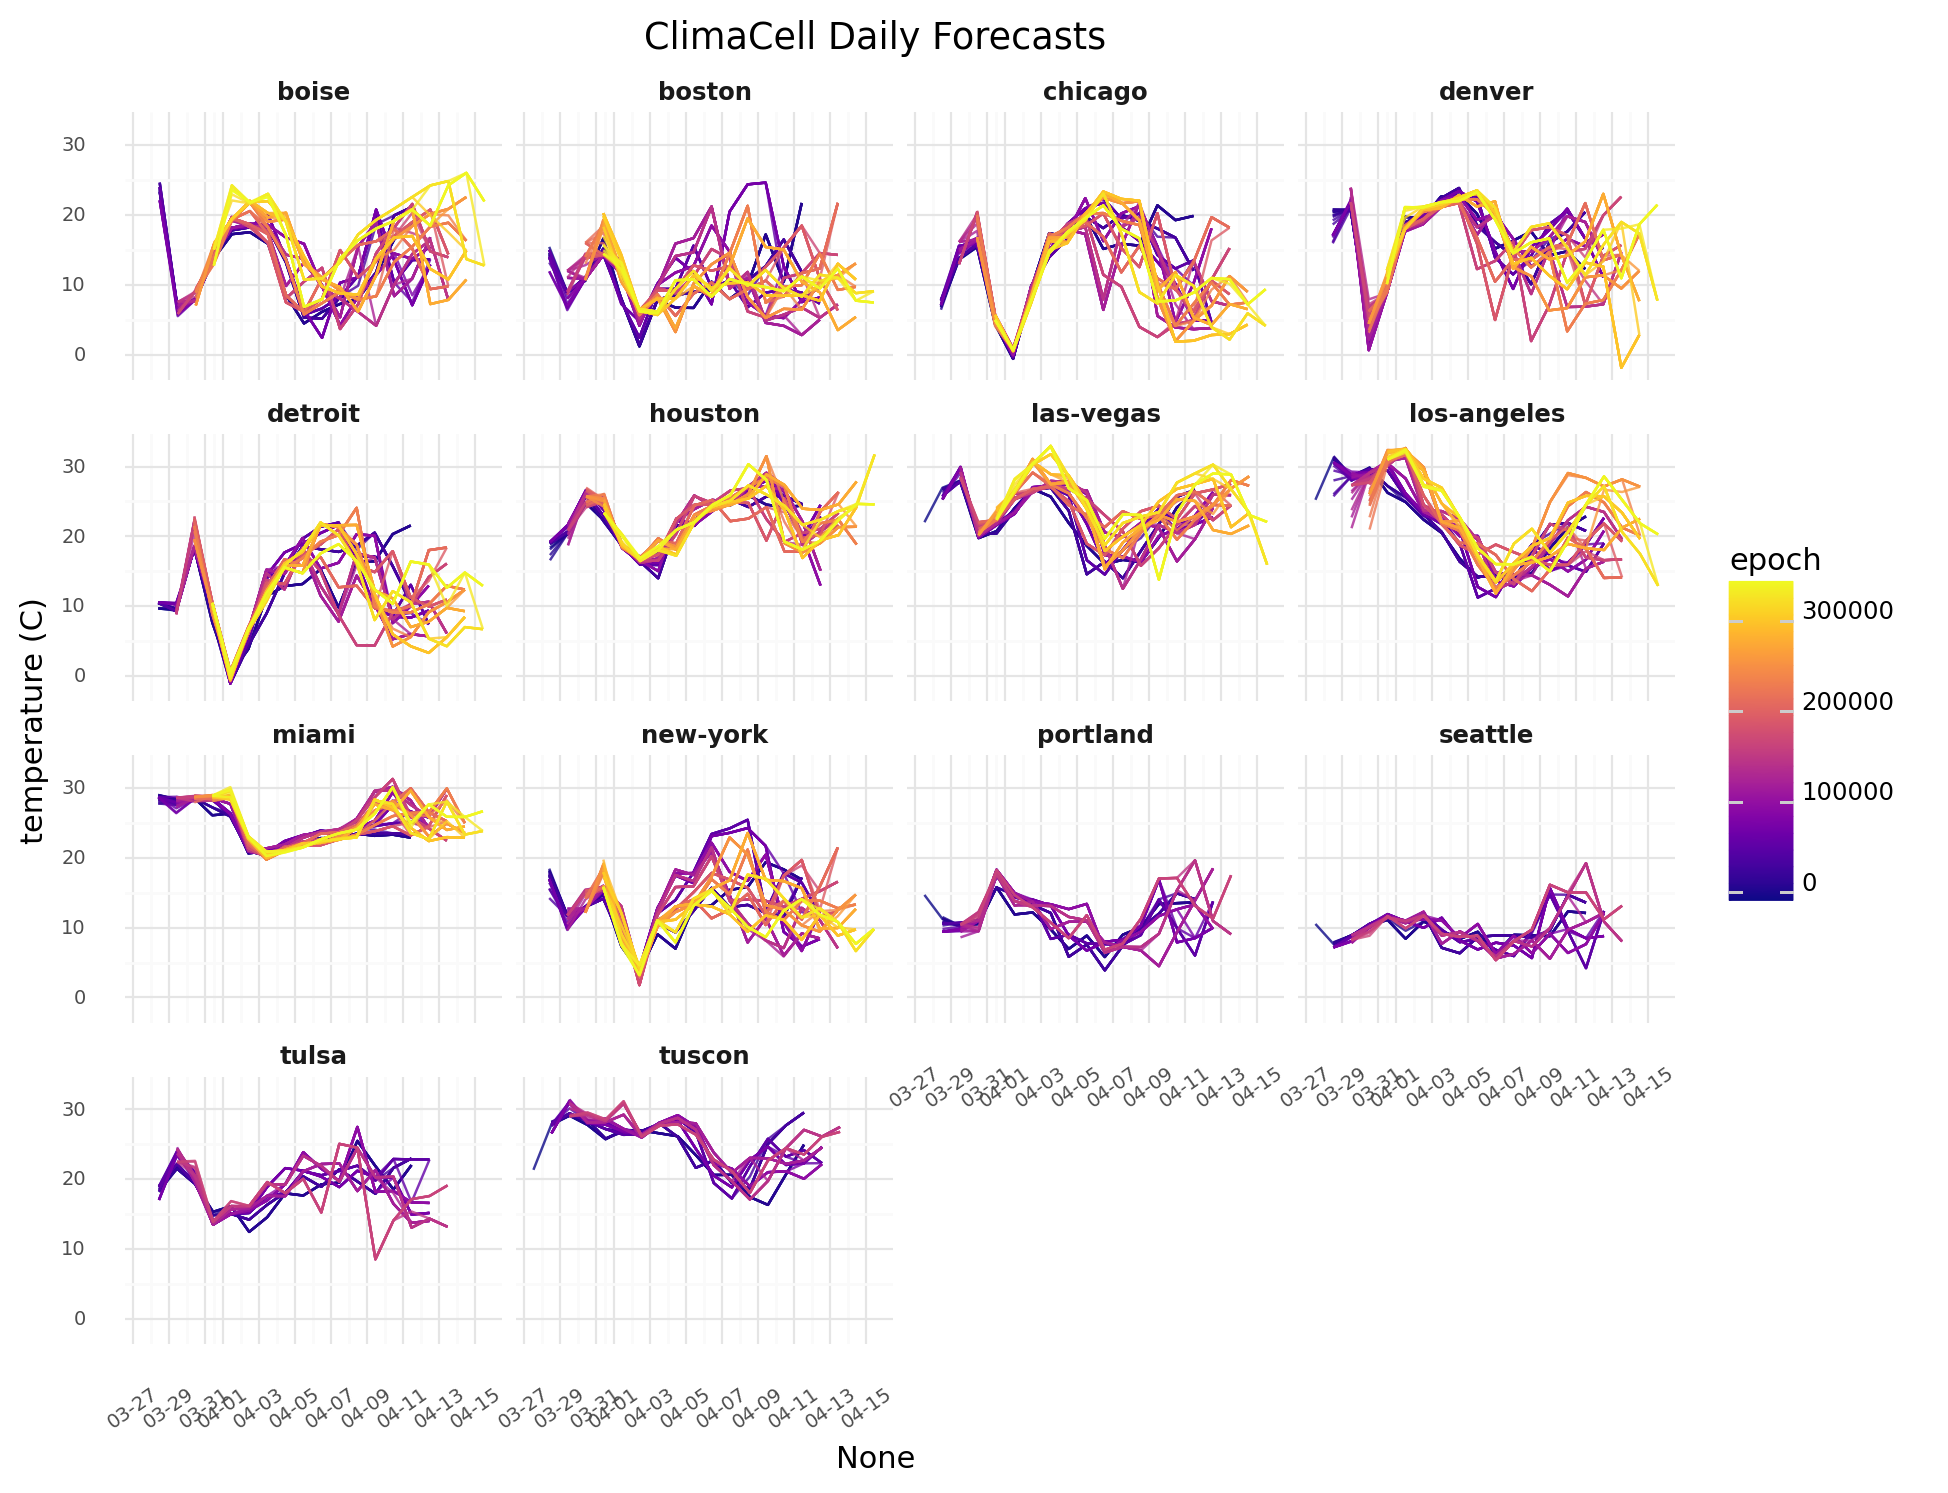

<ggplot: (311022617)>

In [39]:
cc_daily = cc_df.copy()[cc_df.forecast_type == "daily"]
cc_daily["epoch"] = (
    cc_daily["collection_timestamp"] - min(cc_daily["collection_timestamp"])
).dt.total_seconds()

(
    gg.ggplot(cc_daily, gg.aes(x="starttime", y="temperature"))
    + gg.facet_wrap("~ city", ncol=4)
    + gg.geom_line(gg.aes(color="epoch", group="factor(epoch)"), alpha=0.8)
    + gg.scale_x_datetime(date_labels="%m-%d")
    + gg.scale_color_continuous("plasma")
    + gg.theme_minimal()
    + gg.theme(
        figure_size=(10, 8),
        axis_text_x=gg.element_text(angle=35, size=7),
        axis_text_y=gg.element_text(size=7),
        strip_background=gg.element_blank(),
        strip_text=gg.element_text(face="bold"),
    )
    + gg.labs(x="None", y="temperature (C)", title="ClimaCell Daily Forecasts")
)

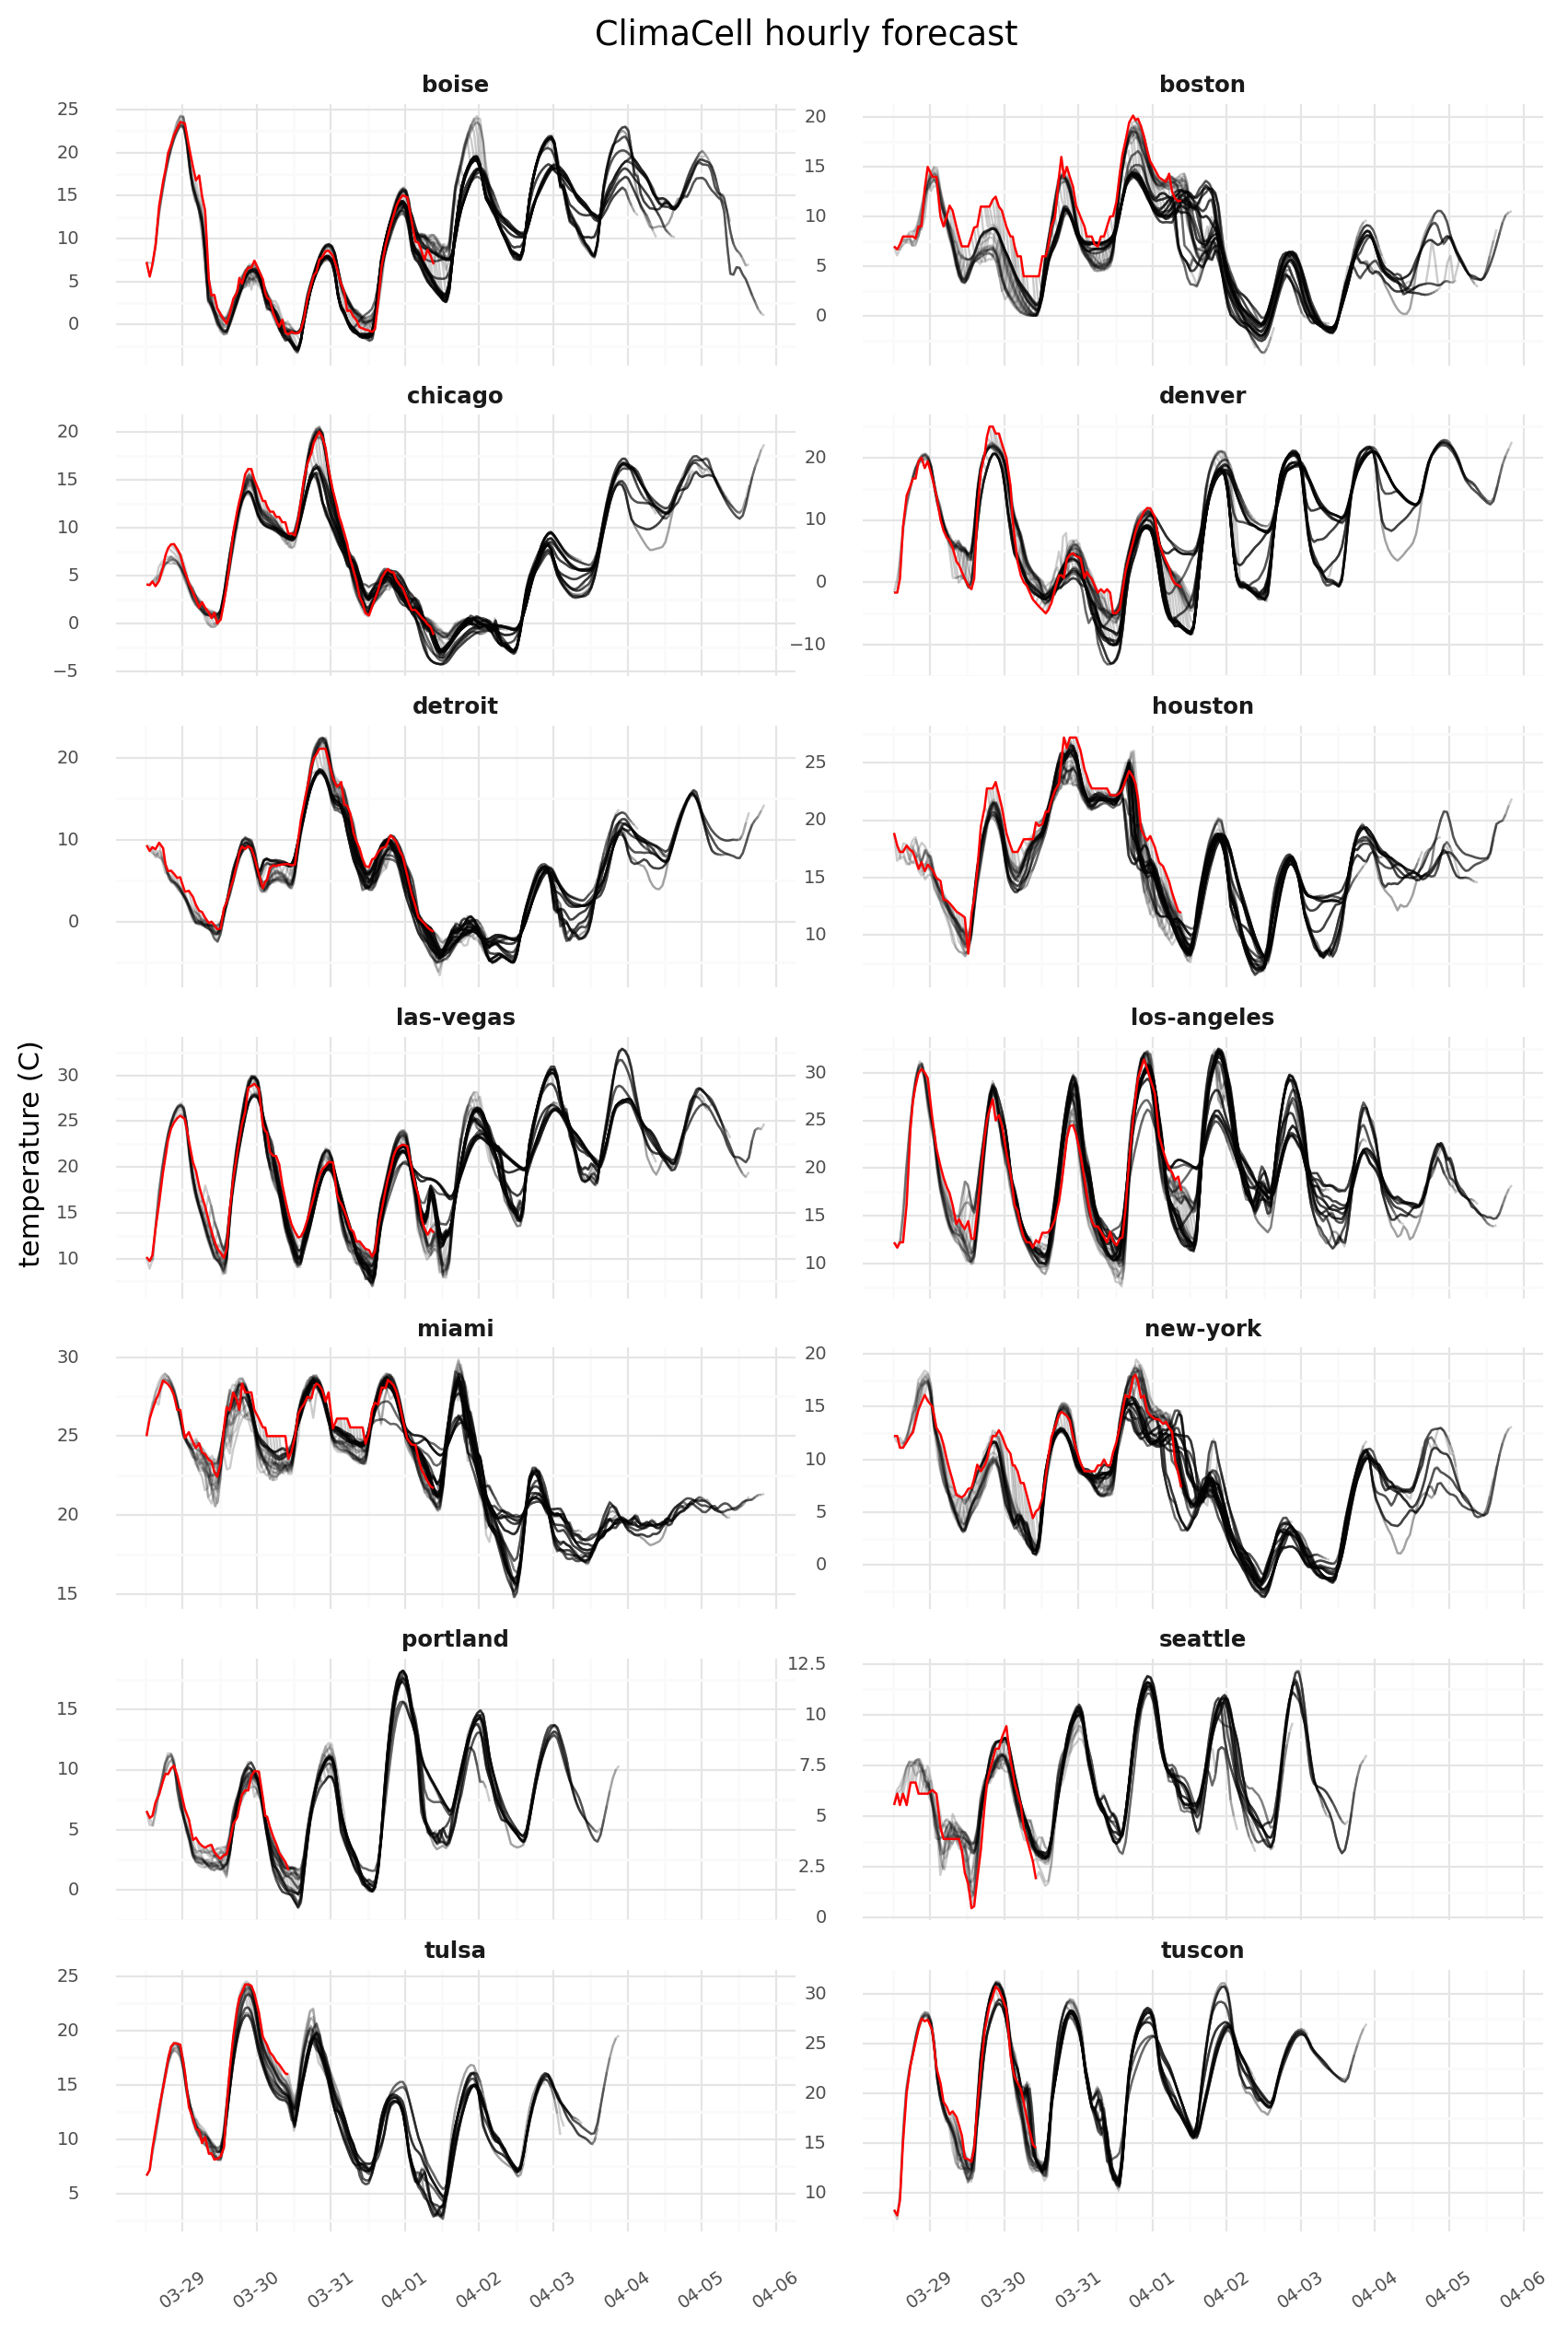

<ggplot: (318326348)>

In [40]:
cc_hourly = cc_df.copy()[cc_df.forecast_type == "hourly"]
cc_current = cc_df.copy()[cc_df.forecast_type == "current"]

plot_forecast_against_actual(
    cc_hourly,
    cc_current,
    x="starttime",
    y="temperature",
) + gg.labs(title="ClimaCell hourly forecast")

## OpenWeatherMap

In [41]:
owm_df = pd.read_pickle(owm_df_path).reset_index(drop=True)
owm_df = owm_df[owm_df.timestamp >= START_DATE]
owm_df.head()

,dt,clouds,wind_speed,temp,feels_like,visibility,weather,weather_description,city,timestamp,forecast_type,pop,time_of_day
0,2021-03-28 22:15:24+00:00,40.0,7.72,8.20,-0.16,10000.0,Clouds,scattered clouds,chicago,2021-03-28 22:15:24.238653,current,NaN,NaN
1,2021-03-29 19:14:27+00:00,1.0,5.66,8.70,2.70,10000.0,Clear,clear sky,detroit,2021-03-29 19:14:28.038494,current,NaN,NaN
2,2021-03-29 07:16:53+00:00,1.0,1.55,17.25,14.89,10000.0,Clear,clear sky,los-angeles,2021-03-29 07:16:53.931909,current,NaN,NaN
3,2021-03-28 18:26:36+00:00,90.0,7.72,7.86,1.50,6437.0,Rain,heavy intensity rain,boston,2021-03-28 18:26:36.136525,current,NaN,NaN
4,2021-03-28 15:14:40+00:00,1.0,3.60,16.57,11.60,10000.0,Clear,clear sky,tuscon,2021-03-28 15:14:41.223449,current,NaN,NaN


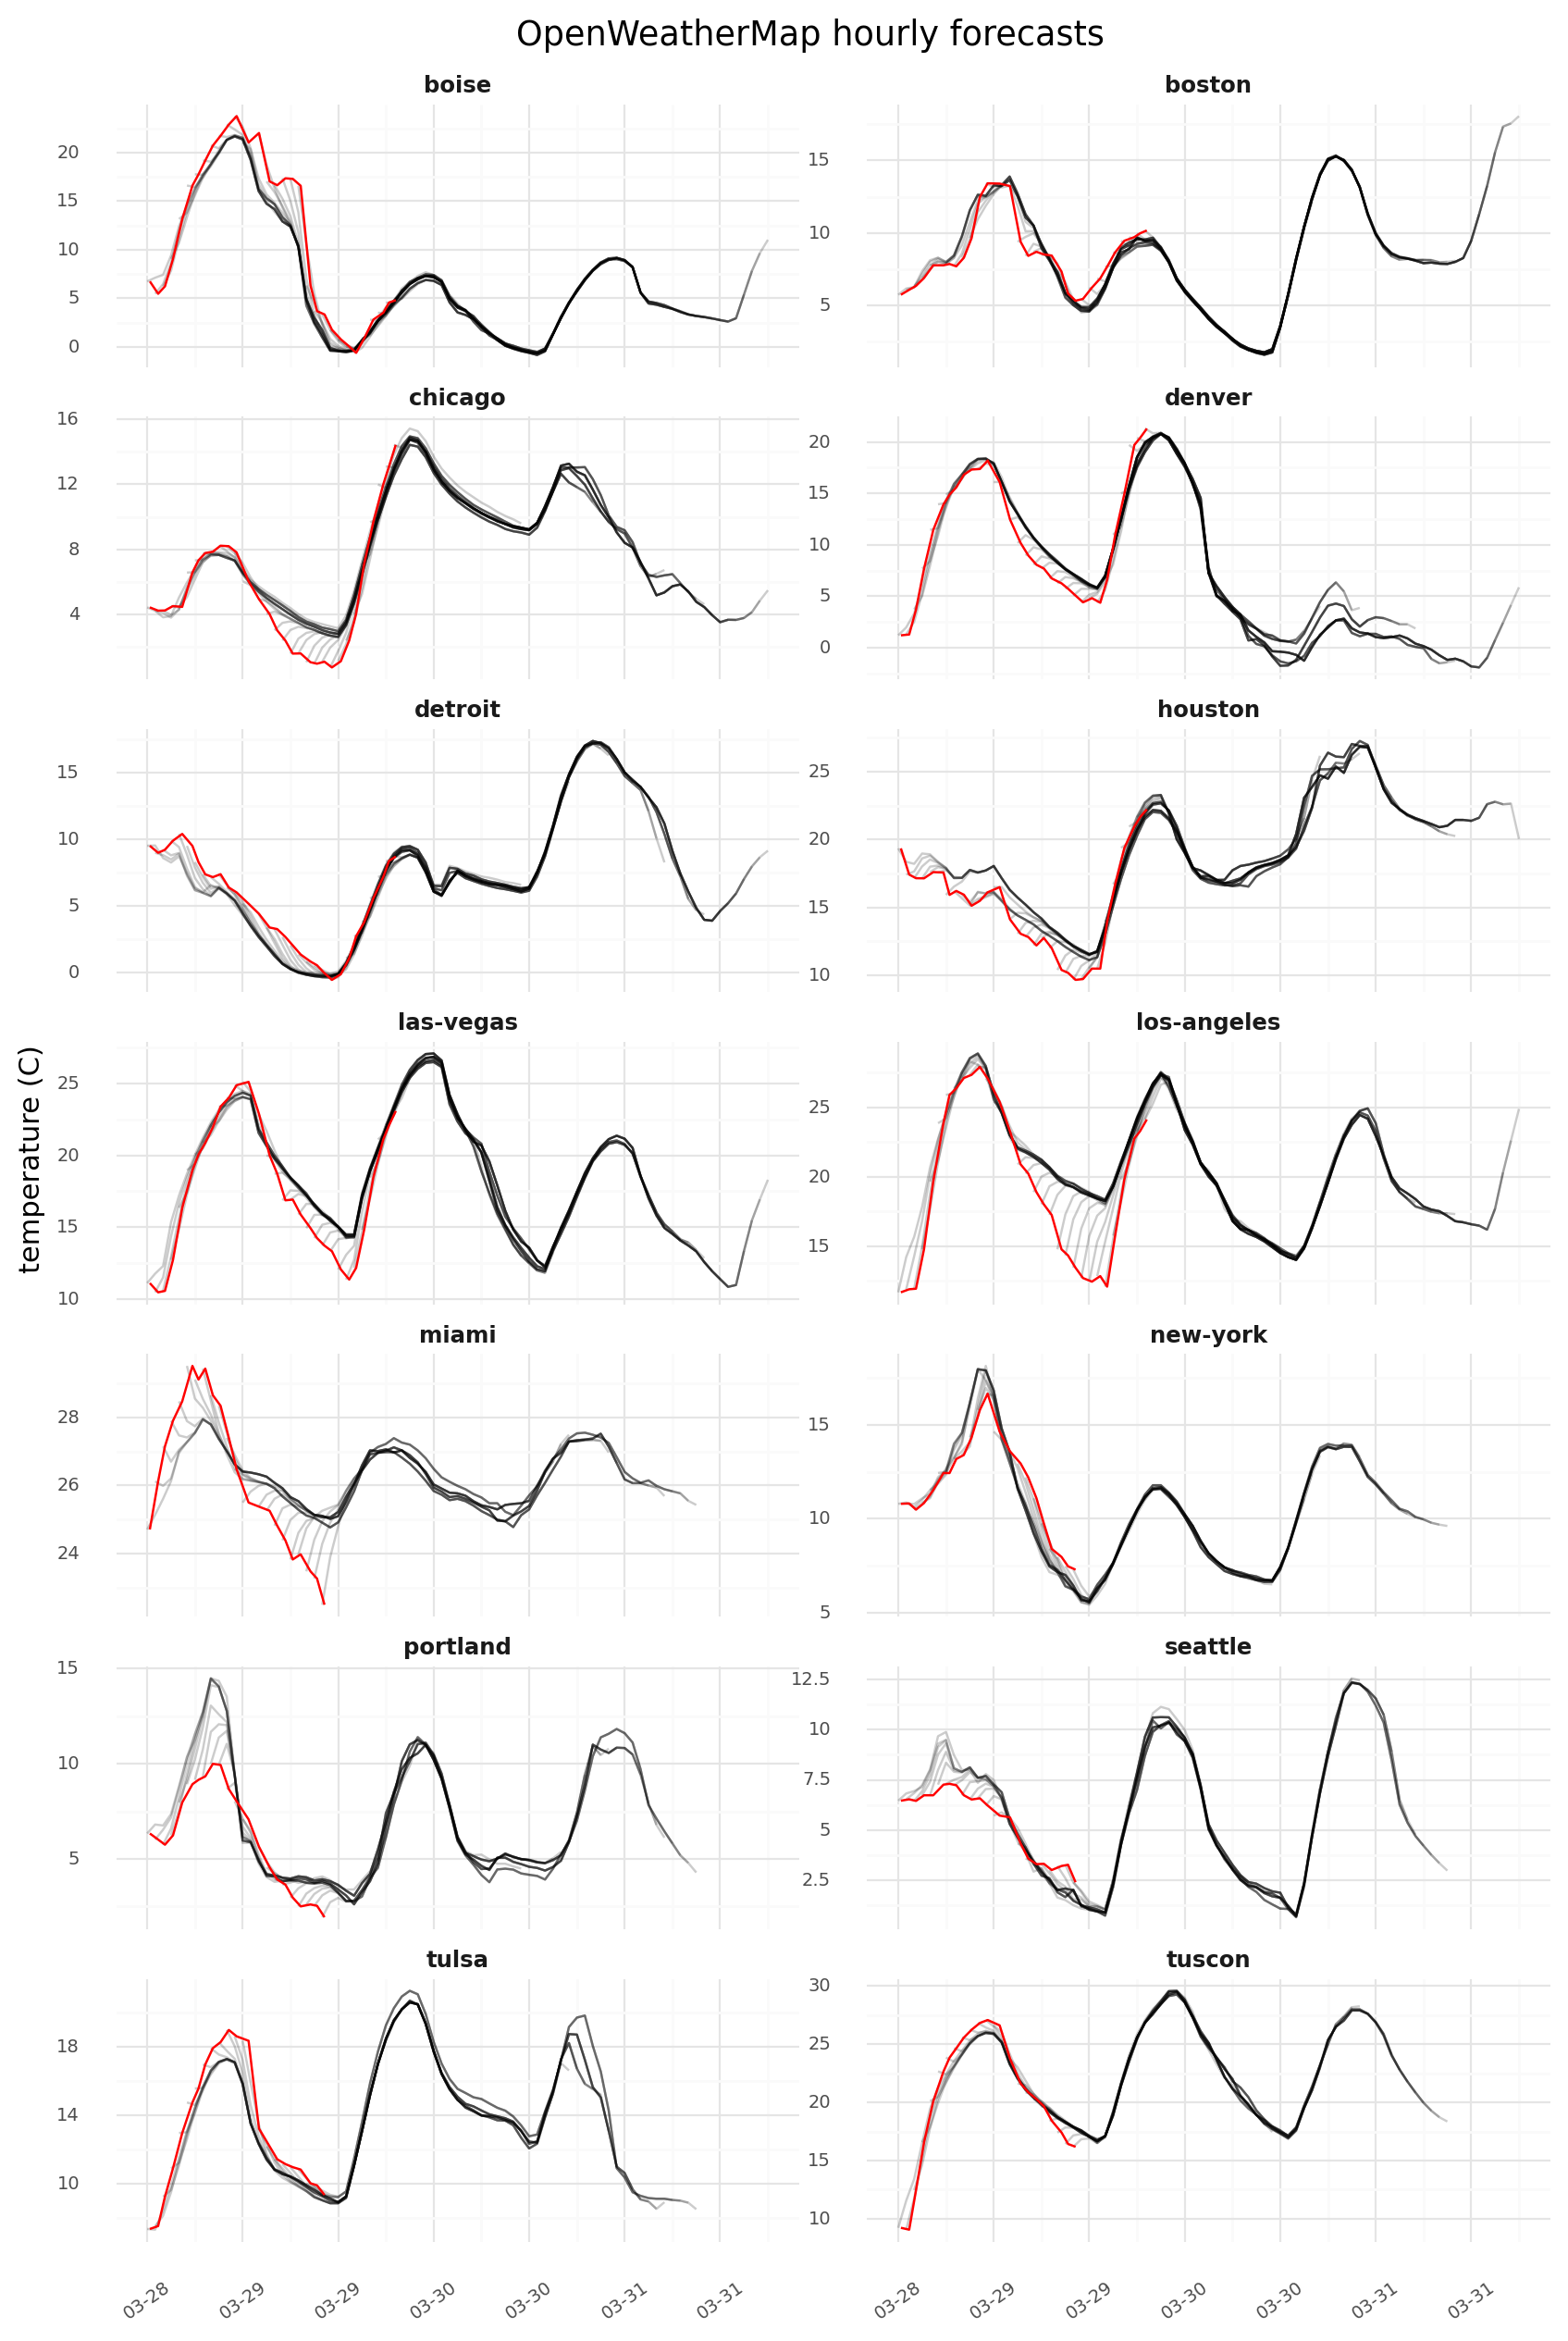

<ggplot: (316198780)>

In [42]:
owm_hourly = owm_df.copy()[owm_df.forecast_type == "hourly"].reset_index(drop=True)
owm_current = owm_df.copy()[owm_df.forecast_type == "current"].reset_index(drop=True)

plot_forecast_against_actual(
    owm_hourly, owm_current, x="dt", y="temp", timestamp_col="timestamp"
) + gg.labs(title="OpenWeatherMap hourly forecasts")